# Bag of Words Meets Bags of Popcorn
## Author: Saad Bin Manjur Adit

#### Using Google's Word2Vec for movie reviews

## Importing libraries

In [1]:
#Librarises
import pandas as pd  #data processing and data level operation
import numpy as np  # Linear Algebra
import os, re
import string
import nltk 
from nltk.corpus import stopwords

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

%matplotlib inline
###For downlaod the nltk
########nltk.download()

In [2]:
#Current working directory
print('current workind directory ==== ',os.getcwd())

#Loading data
train = pd.read_csv('../input/movie-reviews-dataset/labeledTrainData.tsv',delimiter = '\t')
test = pd.read_csv('../input/movie-reviews-dataset/testData.tsv',delimiter = '\t')

train.shape, test.shape

current workind directory ====  /kaggle/working


((25000, 3), (25000, 2))

In [3]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [4]:
train['review'][0]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [5]:
test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [6]:
test['review'][0]

"Naturally in a film who's main themes are of mortality, nostalgia, and loss of innocence it is perhaps not surprising that it is rated more highly by older viewers than younger ones. However there is a craftsmanship and completeness to the film which anyone can enjoy. The pace is steady and constant, the characters full and engaging, the relationships and interactions natural showing that you do not need floods of tears to show emotion, screams to show fear, shouting to show dispute or violence to show anger. Naturally Joyce's short story lends the film a ready made structure as perfect as a polished diamond, but the small changes Huston makes such as the inclusion of the poem fit in neatly. It is truly a masterpiece of tact, subtlety and overwhelming beauty."

In [7]:
print ("number of rows for sentiment 1: {}".format(len(train[train.sentiment == 1])))
print ( "number of rows for sentiment 0: {}".format(len(train[train.sentiment == 0])))

number of rows for sentiment 1: 12500
number of rows for sentiment 0: 12500


There is equal distribution of data

In [8]:
train.groupby('sentiment').describe().transpose()

sentiment                                                      0  \
id     count                                               12500   
       unique                                              12500   
       top                                                7348_3   
       freq                                                    1   
review count                                               12500   
       unique                                              12432   
       top     This show comes up with interesting locations ...   
       freq                                                    3   

sentiment                                                      1  
id     count                                               12500  
       unique                                              12500  
       top                                               6682_10  
       freq                                                    1  
review count                                               12500  
       unique                                              12472  
       top     Red Skelton was still another major star who m...  
       freq                                                    2

In [9]:
#Creating a new col
train['length'] = train['review'].apply(len)
train.head()

,id,sentiment,review,length
0,5814_8,1,With all this stuff going down at the moment w...,2302
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",946
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,2449
3,3630_4,0,It must be assumed that those who praised this...,2245
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,2231


## Data Visualization

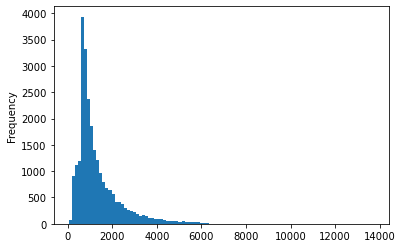

In [10]:
#Histogram of count of letters
train['length'].plot.hist(bins = 100)

In [11]:
train.length.describe()

count    25000.000000
mean      1327.710560
std       1005.239246
min         52.000000
25%        703.000000
50%        981.000000
75%       1617.000000
max      13708.000000
Name: length, dtype: float64

In [12]:
#train[train['length'] == 13708]['review']
train[train['length'] == 13708]['review'].iloc[0]

'Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, bu

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcdcfc468d0>,
      dtype=object)

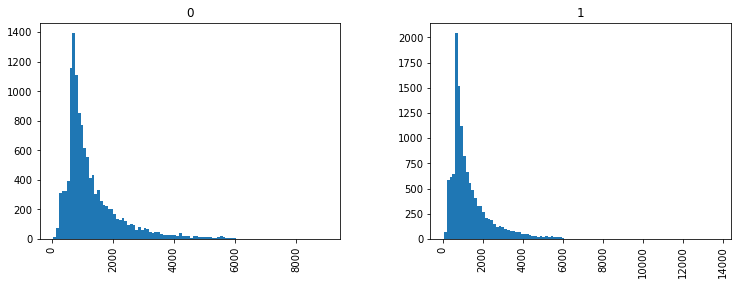

In [13]:
train.hist(column='length', by='sentiment', bins=100,figsize=(12,4))

## Text Preprocessing

In [14]:
from bs4 import BeautifulSoup

#Creating a function for cleaning of data
def clean_text(raw_text):
    # 1. remove HTML tags
    raw_text = BeautifulSoup(raw_text).get_text() 
    
    # 2. removing all non letters from text
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text) 
    
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                           
    
    # 4. Create variable which contain set of stopwords
    stops = set(stopwords.words("english"))                  
    
    # 5. Remove stop word & returning   
    return [w for w in words if not w in stops]

In [15]:
#Cleaning review and also adding a new col as its len count of words
train['clean_review'] = train['review'].apply(clean_text)
train['length_clean_review'] = train['clean_review'].apply(len)
train.head()

,id,sentiment,review,length,clean_review,length_clean_review
0,5814_8,1,With all this stuff going down at the moment w...,2302,"[stuff, going, moment, mj, started, listening,...",219
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",946,"[classic, war, worlds, timothy, hines, enterta...",84
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,2449,"[film, starts, manager, nicholas, bell, giving...",240
3,3630_4,0,It must be assumed that those who praised this...,2245,"[must, assumed, praised, film, greatest, filme...",189
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,2231,"[superbly, trashy, wondrously, unpretentious, ...",210


In [16]:
train.describe()

,sentiment,length,length_clean_review
count,25000.00000,25000.000000,25000.000000
mean,0.50000,1327.710560,119.523560
std,0.50001,1005.239246,90.583576
min,0.00000,52.000000,4.000000
25%,0.00000,703.000000,63.000000
50%,0.50000,981.000000,89.000000
75%,1.00000,1617.000000,146.000000
max,1.00000,13708.000000,1416.000000


In [17]:
#Checking the smallest review
print(train[train['length_clean_review'] == 4]['review'].iloc[0])
print('------After Cleaning------')
print(train[train['length_clean_review'] == 4]['clean_review'].iloc[0])

This movie is terrible but it has some good effects.
------After Cleaning------
['movie', 'terrible', 'good', 'effects']


## Word CLoud

Wordcloud before cleaning

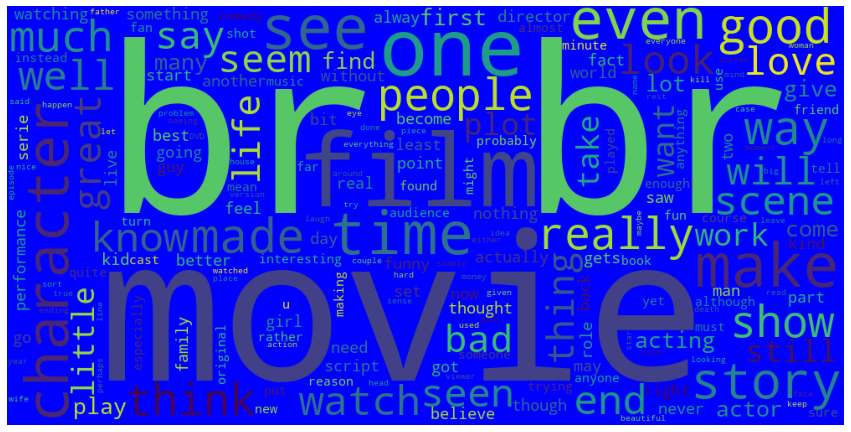

In [18]:
#Plot wordcloud
word_cloud = WordCloud(width = 1000, height = 500, stopwords = STOPWORDS, background_color = 'blue').generate(
                        ''.join(train['review']))

plt.figure(figsize = (15,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

#word_cloud.to_file('aa.png')   #for saving file

## Vectorization

Now we'll convert each review, represented as a list of tokens into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [20]:
# Might take awhile...
bow_transform = CountVectorizer(analyzer=clean_text).fit(train['review'])  #bow = bag of word

# Print total number of vocab words
print(len(bow_transform.vocabulary_))

74065


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new **bow_transformer**

In [21]:
review1 = train['review'][1]
print(review1)

\The Classic War of the Worlds\" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, appreciated the fact that it was not the standard, predictable Hollywood fare that comes out every year, e.g. the Spielberg version with Tom Cruise that had only the slightest resemblance to the book. Obviously, everyone looks for different things in a movie. Those who envision themselves as amateur \"critics\" look only to criticize everything they can. Others rate a movie on more important bases,like being entertained, which is why most people never agree with the \"critics\". We enjoyed the effort Mr. Hines put into being faithful to H.G. Wells' classic novel, and we found it to be very entertaining. This made it easy to overlook what the \"critics\" perceive to be its shortcomings."


Now let's see its vector representation:

In [22]:
bow1 = bow_transform.transform([review1])
print(bow1)
print(bow1.shape)

  (0, 1153)	1
  (0, 1860)	1
  (0, 2877)	1
  (0, 5089)	1
  (0, 7345)	2
  (0, 11671)	3
  (0, 12493)	1
  (0, 14613)	1
  (0, 14617)	3
  (0, 14782)	1
  (0, 17310)	1
  (0, 19658)	1
  (0, 19759)	1
  (0, 20008)	2
  (0, 20901)	1
  (0, 21030)	1
  (0, 21035)	2
  (0, 21147)	1
  (0, 21748)	1
  (0, 21754)	1
  (0, 21757)	1
  (0, 22499)	1
  (0, 22584)	1
  (0, 22585)	1
  (0, 22788)	1
  :	:
  (0, 45216)	1
  (0, 45629)	2
  (0, 46521)	1
  (0, 46850)	1
  (0, 48251)	1
  (0, 48288)	1
  (0, 50446)	1
  (0, 51816)	1
  (0, 52690)	1
  (0, 53240)	1
  (0, 54251)	1
  (0, 58936)	1
  (0, 59991)	1
  (0, 61334)	1
  (0, 61943)	1
  (0, 63259)	1
  (0, 65725)	1
  (0, 66191)	1
  (0, 66463)	1
  (0, 70380)	1
  (0, 71340)	1
  (0, 71498)	1
  (0, 71821)	2
  (0, 72911)	1
  (0, 73396)	1
(1, 74065)


Here 2 and 1 represent the occurance of word in the text phase & Number like  '73396' are index of that particular word

In [23]:
print(bow_transform.get_feature_names()[71821])
print(bow_transform.get_feature_names()[72911])

wells
worlds


Above both words stores on that particular index

In [24]:
#Creating bag of words for our review variable
review_bow = bow_transform.transform(train['review'])

Checking the shape and non zero occurances of our sparse matrix that we have just generated

In [25]:
print('Shape of Sparse Matrix: ', review_bow.shape)
print('Amount of Non-Zero occurences: ', review_bow.nnz)

Shape of Sparse Matrix:  (25000, 74065)
Amount of Non-Zero occurences:  2450404


Checking the sparsity of sparse matrix

In [26]:
sparsity = (100.0 * review_bow.nnz / (review_bow.shape[0] * review_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.1323380274083575


## TF-IDF
Term Frequency - Inverse Document Frequency.

After the counting, the term weighting and normalization can be done with tf-idf

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(review_bow)
tfidf1 = tfidf_transformer.transform(bow1)
print(tfidf1)

  (0, 73396)	0.061582405387422844
  (0, 72911)	0.10916204090045824
  (0, 71821)	0.24678226776886478
  (0, 71498)	0.06130848347869254
  (0, 71340)	0.07054912976037264
  (0, 70380)	0.06691025207731116
  (0, 66463)	0.08376908496574231
  (0, 66191)	0.11391853286104583
  (0, 65725)	0.05408056138661737
  (0, 63259)	0.1047755178999042
  (0, 61943)	0.08811567227327795
  (0, 61334)	0.11302952635114163
  (0, 59991)	0.10986956065151147
  (0, 58936)	0.11997053429431336
  (0, 54251)	0.11268631063864525
  (0, 53240)	0.13073660913364496
  (0, 52690)	0.0824732205199774
  (0, 51816)	0.05986262652464556
  (0, 50446)	0.077539268028452
  (0, 48288)	0.13122486190259133
  (0, 48251)	0.04143735557967593
  (0, 46850)	0.11689701180182505
  (0, 46521)	0.06665775481300043
  (0, 45629)	0.14376840111740952
  (0, 45216)	0.08006252757098449
  :	:
  (0, 22788)	0.10110289576849556
  (0, 22585)	0.13850169616266522
  (0, 22584)	0.10403788202119751
  (0, 22499)	0.05424308473387671
  (0, 21757)	0.06083289839379746
  (0, 2

We'll go ahead and check what is the IDF (inverse document frequency) of the word `"war"` and of word `"book"`?

In [28]:
print(tfidf_transformer.idf_[bow_transform.vocabulary_['war']])
print(tfidf_transformer.idf_[bow_transform.vocabulary_['book']])

4.070495818949949
3.8577509748566374


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [29]:
review_tfidf = tfidf_transformer.transform(review_bow)
print(review_tfidf.shape)

(25000, 74065)


## Modeling Part

#### Train Test Split

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train['review'], train['sentiment'], test_size=0.22, random_state=101)

len(X_train), len(X_test), len(X_train) + len(X_test)

(19500, 5500, 25000)

#### Result Function

In [31]:
from sklearn.metrics import classification_report
#Predicting & Stats Function
def pred(predicted,compare):
    cm = pd.crosstab(compare,predicted)
    TN = cm.iloc[0,0]
    FN = cm.iloc[1,0]
    TP = cm.iloc[1,1]
    FP = cm.iloc[0,1]
    print("CONFUSION MATRIX ------->> ")
    print(cm)
    print()
    
    ##check accuracy of model
    print('Classification paradox :------->>')
    print('Accuracy :- ', round(((TP+TN)*100)/(TP+TN+FP+FN),2))
    print()
    print('False Negative Rate :- ',round((FN*100)/(FN+TP),2))
    print()
    print('False Postive Rate :- ',round((FP*100)/(FP+TN),2))
    print()
    print(classification_report(compare,predicted))

## Training Model

### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(random_state=101)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_train)
pred(predictions,y_train)

CONFUSION MATRIX ------->> 
col_0         0     1
sentiment            
0          9042   682
1           499  9277

Classification paradox :------->>
Accuracy :-  93.94

False Negative Rate :-  5.1

False Postive Rate :-  7.01

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      9724
           1       0.93      0.95      0.94      9776

    accuracy                           0.94     19500
   macro avg       0.94      0.94      0.94     19500
weighted avg       0.94      0.94      0.94     19500



In [33]:
#Test Set Result
predictions = pipeline.predict(X_test)
pred(predictions,y_test)

CONFUSION MATRIX ------->> 
col_0         0     1
sentiment            
0          2424   352
1           267  2457

Classification paradox :------->>
Accuracy :-  88.75

False Negative Rate :-  9.8

False Postive Rate :-  12.68

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2776
           1       0.87      0.90      0.89      2724

    accuracy                           0.89      5500
   macro avg       0.89      0.89      0.89      5500
weighted avg       0.89      0.89      0.89      5500



### Naive Bayes Model

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_train)
pred(predictions,y_train)

CONFUSION MATRIX ------->> 
col_0         0     1
sentiment            
0          9054   670
1           843  8933

Classification paradox :------->>
Accuracy :-  92.24

False Negative Rate :-  8.62

False Postive Rate :-  6.89

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      9724
           1       0.93      0.91      0.92      9776

    accuracy                           0.92     19500
   macro avg       0.92      0.92      0.92     19500
weighted avg       0.92      0.92      0.92     19500



In [35]:
#Result on Test Case
predictions = pipeline.predict(X_test)
pred(predictions,y_test)

CONFUSION MATRIX ------->> 
col_0         0     1
sentiment            
0          2423   353
1           352  2372

Classification paradox :------->>
Accuracy :-  87.18

False Negative Rate :-  12.92

False Postive Rate :-  12.72

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2776
           1       0.87      0.87      0.87      2724

    accuracy                           0.87      5500
   macro avg       0.87      0.87      0.87      5500
weighted avg       0.87      0.87      0.87      5500



### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier(n_estimators = 500)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_train)
pred(predictions,y_train)

CONFUSION MATRIX ------->> 
col_0         0     1
sentiment            
0          9724     0
1             0  9776

Classification paradox :------->>
Accuracy :-  100.0

False Negative Rate :-  0.0

False Postive Rate :-  0.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9724
           1       1.00      1.00      1.00      9776

    accuracy                           1.00     19500
   macro avg       1.00      1.00      1.00     19500
weighted avg       1.00      1.00      1.00     19500



In [37]:
#Test Set Result
predictions = pipeline.predict(X_test)
pred(predictions,y_test)

CONFUSION MATRIX ------->> 
col_0         0     1
sentiment            
0          2382   394
1           364  2360

Classification paradox :------->>
Accuracy :-  86.22

False Negative Rate :-  13.36

False Postive Rate :-  14.19

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2776
           1       0.86      0.87      0.86      2724

    accuracy                           0.86      5500
   macro avg       0.86      0.86      0.86      5500
weighted avg       0.86      0.86      0.86      5500



## Final Model Will be Logistic Regression

In [38]:
#Saving Output
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline_logit = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(random_state=101)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline_logit.fit(train['review'],train['sentiment'])
test['sentiment'] = pipeline_logit.predict(test['review'])

In [39]:
test.head(5)

,id,review,sentiment
0,12311_10,Naturally in a film who's main themes are of m...,1
1,8348_2,This movie is a disaster within a disaster fil...,0
2,5828_4,"All in all, this is a movie for kids. We saw i...",1
3,7186_2,Afraid of the Dark left me with the impression...,1
4,12128_7,A very accurate depiction of small time mob li...,1


In [40]:
output = test[['id','sentiment']]
print(output)

             id  sentiment
0      12311_10          1
1        8348_2          0
2        5828_4          1
3        7186_2          1
4       12128_7          1
...         ...        ...
24995   2155_10          1
24996     59_10          1
24997    2531_1          0
24998    7772_8          1
24999  11465_10          1

[25000 rows x 2 columns]


### Submission File

In [41]:
#output.to_csv( "output.csv", index=False, quoting=3 )